In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import glob
import os
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# code for smooth switch point:
# https://gist.github.com/junpenglao/f7098c8e0d6eadc61b3e1bc8525dd90d
import theano.tensor as tt
from pymc3.distributions.transforms import ElemwiseTransform, Transform

class Ordered(ElemwiseTransform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        x, = draw_values([x], point=point)
        return self.forward(x)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

ordered = Ordered()


class Composed(Transform):
    def __init__(self, transform1, transform2):
        self._transform1 = transform1
        self._transform2 = transform2
        self.name = '_'.join([transform1.name, transform2.name])

    def forward(self, x):
        return self._transform2.forward(self._transform1.forward(x))

    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._transform1.backward(self._transform2.backward(y))

    def jacobian_det(self, y):
        y2 = self._transform2.backward(y)
        det1 = self._transform1.jacobian_det(y2)
        det2 = self._transform2.jacobian_det(y)
        return det1 + det2
    
def logistic(L, x0, k=50, t_=np.linspace(0., 1., 1000)):
    x0 = x0*(t_.max()-t_.min()) + t_.min()  # scale x0 to t_
    return L/(1+tt.exp(-k*(t_-x0)))

In [15]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'lightgray', 'red'])
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, ax=None, **kwargs):

    ''' values is a n-by-m array'''

    values[np.isnan(values)] = 0
    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y = 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

    im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
    if ax is None:
        cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        cax = ax
#    sns.despine()

    return cax

def visualize_stn_model(df, dependent_var='y', ax=None, vmin=None, vmax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    # recode... ugly
    df['pc1_sector_name'] = 'vmd_' + df['pc1_sector_number'].astype(int).astype(str)
    df['pc2_sector_name'] = 'mml_' + df['pc2_sector_number'].astype(int).astype(str)
    vmd_labels = df['pc1_sector_name'].unique()
    mml_labels = df['pc2_sector_name'].unique()
    
    unstacked = df.groupby(['pc1_sector_name', 'pc2_sector_name'])[dependent_var].mean().unstack(1).ix[vmd_labels, mml_labels]

    if vmin is None:
        vmin = np.nanpercentile(unstacked.values, 5)
    if vmax is None:
        vmax = np.nanpercentile(unstacked.values, 95)
    plot_ellipse_values(unstacked.values, ax=ax, vmin=vmin, vmax=vmax, **kwargs)
    ax.axis('off')
    return ax

def plot_intensity_across_axis(df, dependent_var='y', x_axis='pc1_mm', ax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, 1)
        
    data_per_coordinate = df.groupby([x_axis])[dependent_var].mean().reset_index()
    ax.plot(data_per_coordinate[x_axis], data_per_coordinate[dependent_var], **kwargs)
    ax.set_xlabel(x_axis)
    ax.set_ylabel('Rate')
    return ax

In [16]:
def np_logistic(L, x0, k=50, t_=np.linspace(0., 1., 1000)):
    x0 = x0*(t_.max()-t_.min()) + t_.min()  # scale x0 to t_
    return L/(1+np.exp(-k*(t_-x0)))

def ppc_stn(df, trace, distribution='poisson', model_n=1, n_samples=500):
    
    trace_df = pm.trace_to_dataframe(trace)
    out_array = np.empty((df.shape[0], n_samples))

    for i in np.arange(n_samples):
        if i % 10 == 0:
            print('.', end='')
        random_row = np.random.randint(low=0, high=trace_df.shape[0])
        
        if model_n == 1:
            ev = np.exp(trace_df.iloc[random_row]['intercept'])
        elif model_n == 2:
            ev = np.exp(trace_df.iloc[random_row]['intercept'] + \
                        trace_df.iloc[random_row]['beta_pca_1']*df['pc1_sector_coordinate'].values)
        elif model_n == 3:
            pass
        elif model_n == 4:
            ev = np.exp(trace_df.iloc[random_row]['intercept'] + \
                        trace_df.iloc[random_row]['beta_pca_1']*df['pc1_sector_coordinate'].values + \
                        trace_df.iloc[random_row]['beta_pca_2']*df['pc2_sector_coordinate'].values + \
                        trace_df.iloc[random_row]['beta_slice']*df['slice_sector_coordinate'].values)
            
        elif model_n == 5:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            ev = np.exp(this_int + \
                        this_int*np_logistic(this_lambda_0, this_b_0, k=-50, t_=df['pc1_mm_perc'].values) +\
                        this_int*np_logistic(this_lambda_1, this_b_1, k=50, t_=df['pc1_mm_perc'].values))
            
        elif model_n == 6:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            this_k_0 = trace_df.iloc[random_row]['k__0']
            this_k_1 = trace_df.iloc[random_row]['k__1']
            ev = np.exp(this_int + \
                        this_int*np_logistic(this_lambda_0, this_b_0, k=-np.exp(this_k_0), t_=df['pc1_mm_perc'].values) +\
                        this_int*np_logistic(this_lambda_1, this_b_1, k=np.exp(this_k_1), t_=df['pc1_mm_perc'].values))
                        
        elif model_n == 7:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            this_beta_1 = trace_df.iloc[random_row]['beta_pca_1']
            this_beta_2 = trace_df.iloc[random_row]['beta_pca_2']
            this_beta_slice = trace_df.iloc[random_row]['beta_slice']
            
            O_vec = this_beta_1*df['pc1_mm_perc'].values + \
                    this_beta_2*df['pc2_mm_perc'].values + \
                    this_beta_slice*df['slice_sector_perc'].values
        
            # set O to scale 0-1, use this for cut-off
#            O_vec = (O_vec-O_vec.min()/(O_vec.max()-O_vec.min()))

            ev = np.exp(this_int + \
                        this_int*np_logistic(this_lambda_0, this_b_0, k=-50, t_=O_vec) +\
                        this_int*np_logistic(this_lambda_1, this_b_1, k=50, t_=O_vec))
                        
        if distribution == 'poisson':
            out_array[:,i] = ev
        else:
            out_array[:,i] = ev  # do something with variance as well?
    return out_array

In [17]:
def load_model_traces(subject_id, stain, model_n, distribution, output_dir='./models'):
    trace_fn = os.path.join(output_dir, 'sub-{}_stain-{}_model-{}_distribution-{}_type-traces.pkl').format(subject_id, stain, model_n, distribution)
    model_fn = os.path.join(output_dir, 'sub-{}_stain-{}_model-{}_distribution-{}_type-model.pkl').format(subject_id, stain, model_n, distribution)

    with open(model_fn, 'rb') as f:
        model = pkl.load(f)
    with open(trace_fn, 'rb') as f:
        traces = pkl.load(f)
    return model, traces

In [18]:
# load data
df = pd.read_pickle('./data_fwhm-0.3.pkl')

In [19]:
#df['slice_sector_perc'] = df['slice_mm_perc']
subj_id = 13095 #13095#14037
stain = 'GABRA3'
model_n = 7
distribution = 'poisson'
model, traces = load_model_traces(subj_id, stain, model_n, distribution)
data_df_idx = (df.subject_id==subj_id) & (df.stain==stain)
# model_df_idx = (subj_id, 'poisson', stain, str(model_n))

ppc = ppc_stn(df=df.loc[data_df_idx,:], trace=traces, model_n=model_n, n_samples=500)

..................................................

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,2.330275,0.229982,0.022499,2.198185e+00,2.866803,7.513877,35.203742
lambdad__0,0.264763,0.093550,0.009143,5.377305e-02,0.323397,7.523307,22.260517
lambdad__1,0.274416,0.240179,0.023500,-3.501075e-01,0.409916,7.528194,20.367699
beta_pca_1,0.382344,0.320294,0.030559,1.584402e-01,1.086694,7.862174,4.877182
beta_pca_2,0.215934,0.199325,0.019484,5.591251e-07,0.832448,7.608498,9.015766
beta_slice,3.164183,3.952865,0.380236,7.447776e-01,11.145052,7.745373,5.924600
b__0,0.404214,0.067706,0.006630,2.356215e-01,0.439670,7.512691,38.891386
b__1,0.777183,0.168349,0.016528,3.604826e-01,0.994246,7.508004,125.103737


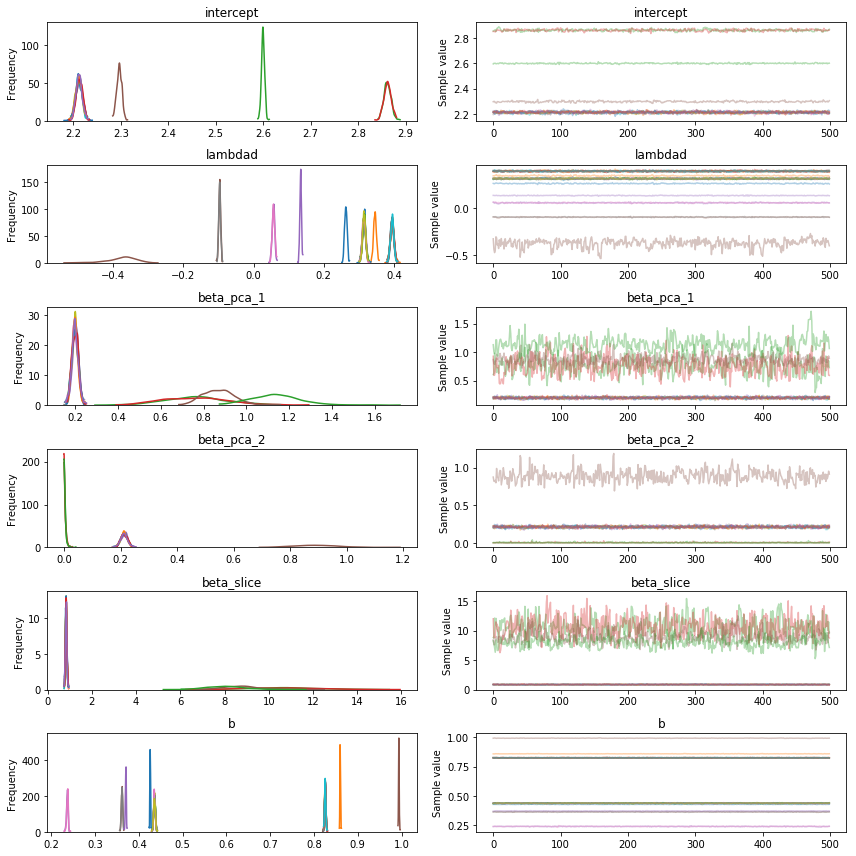

In [20]:
pm.traceplot(traces)
display(pm.summary(traces))

In [21]:
ppc_mean = ppc.mean(axis=1)
df_tmp = df.loc[data_df_idx,:].copy()
df_tmp['y_predicted'] = ppc_mean

In [22]:
df_tmp.shape

(8400, 21)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


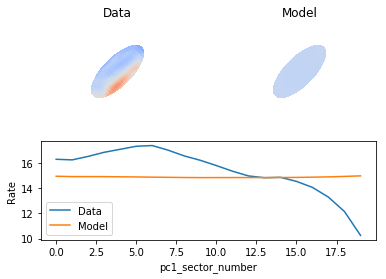

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
ax_stn_data = plt.subplot(gs[0,0])
ax_stn_model = plt.subplot(gs[0,1])
ax_graph = plt.subplot(gs[1,:])
vmin = np.nanpercentile(df_tmp['rate'], 5)
vmax = np.nanpercentile(df_tmp['rate'], 95)

visualize_stn_model(df_tmp, dependent_var='rate', ax=ax_stn_data, vmin=vmin, vmax=vmax)
visualize_stn_model(df_tmp, dependent_var='y_predicted', ax=ax_stn_model, vmin=vmin, vmax=vmax)
plot_intensity_across_axis(df_tmp, dependent_var='rate', ax=ax_graph, x_axis='pc1_sector_number', label='Data')
plot_intensity_across_axis(df_tmp, dependent_var='y_predicted', ax=ax_graph, x_axis='pc1_sector_number', label='Model')

ax_stn_data.set_title('Data')
ax_stn_model.set_title('Model')
ax_graph.legend()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-package

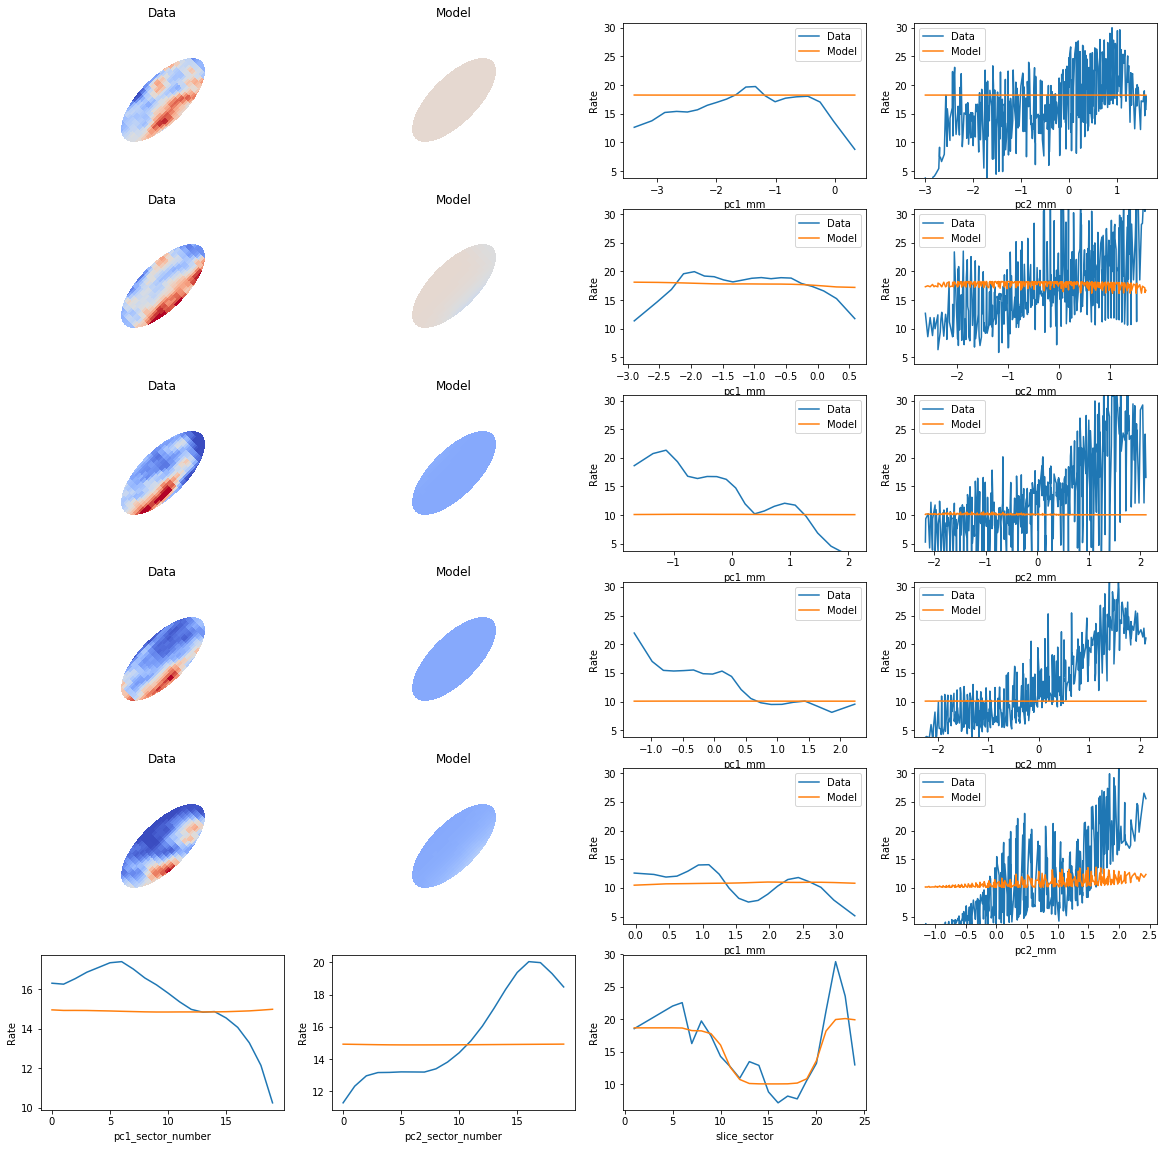

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(6, 4)

vmin = np.nanpercentile(df_tmp['rate'], 5)
vmax = np.nanpercentile(df_tmp['rate'], 95)
for row_n, slice_id in enumerate([1,5,8,10,15]):
    df_this_slice = df_tmp.loc[df_tmp.slice_sector==df_tmp.slice_sector.unique()[slice_id]]
    ax_stn_data = plt.subplot(gs[row_n,0])
    ax_stn_model = plt.subplot(gs[row_n,1])
    ax_graph_pc1 = plt.subplot(gs[row_n,2])
    ax_graph_pc2 = plt.subplot(gs[row_n,3])

    visualize_stn_model(df_this_slice, dependent_var='rate', ax=ax_stn_data, vmin=vmin, vmax=vmax)
    visualize_stn_model(df_this_slice, dependent_var='y_predicted', ax=ax_stn_model, vmin=vmin, vmax=vmax)
    plot_intensity_across_axis(df_this_slice, dependent_var='rate', ax=ax_graph_pc1, label='Data')
    plot_intensity_across_axis(df_this_slice, dependent_var='y_predicted', ax=ax_graph_pc1, label='Model')
    plot_intensity_across_axis(df_this_slice, x_axis='pc2_mm', dependent_var='rate', ax=ax_graph_pc2, label='Data')
    plot_intensity_across_axis(df_this_slice, x_axis='pc2_mm', dependent_var='y_predicted', ax=ax_graph_pc2, label='Model')

    ax_stn_data.set_title('Data')
    ax_stn_model.set_title('Model')
    ax_graph_pc1.legend()
    ax_graph_pc1.set_ylim(vmin, vmax)
    ax_graph_pc2.legend()
    ax_graph_pc2.set_ylim(vmin, vmax)

# some overall plots (across pc1, pc2, slice)
plot_intensity_across_axis(df_tmp, x_axis='pc1_sector_number', dependent_var='rate', ax=plt.subplot(gs[-1,0]), label='Data')
plot_intensity_across_axis(df_tmp, x_axis='pc1_sector_number', dependent_var='y_predicted', ax=plt.subplot(gs[-1,0]), label='Model')
plot_intensity_across_axis(df_tmp, x_axis='pc2_sector_number', dependent_var='rate', ax=plt.subplot(gs[-1,1]), label='Data')
plot_intensity_across_axis(df_tmp, x_axis='pc2_sector_number', dependent_var='y_predicted', ax=plt.subplot(gs[-1,1]), label='Model')
plot_intensity_across_axis(df_tmp, x_axis='slice_sector', dependent_var='rate', ax=plt.subplot(gs[-1,2]), label='Data')
plot_intensity_across_axis(df_tmp, x_axis='slice_sector', dependent_var='y_predicted', ax=plt.subplot(gs[-1,2]), label='Model')

plt.gcf().set_size_inches(20, 20)